<a href="https://colab.research.google.com/github/RPGraciotti/BootCampAlura/blob/main/Modulo_2/Aula_5_Manipulando_datas_e_gerando_novas_analises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aula 5
## Preparando conteúdo anterior

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns
from datetime import date

df = pd.read_csv("https://raw.githubusercontent.com/RPGraciotti/agendamento-hospitalar/main/dados/A160324189_28_143_208.csv", encoding = "ISO-8859-1",
                 skiprows = 3, sep = ";", skipfooter = 12,
                 thousands = ".", decimal = ",", engine = "python")
pd.options.display.float_format = "{:.2f}".format
use_col = df.mean().index.tolist()
use_col.insert(0, "Unidade da Federação")
use = df.loc[:,use_col]
use = use.set_index("Unidade da Federação")
use.sort_values(by = "Total") # crescente
total_ord = use.sort_values(by = "Total", ascending = False) # decrescente
total_ord = total_ord.drop("Total", axis = 1)
main_cols = total_ord.columns[6:]
total_ord = total_ord[main_cols]
total_ord = total_ord/1000000
total_ord.index = total_ord.index.str[3:] # Matar esse problema aqui de vez
ultimo_mes = total_ord.columns[-1]
gastos_ultimo_mes = total_ord[ultimo_mes]
gastos_prop_estado = gastos_ultimo_mes / gastos_ultimo_mes.sum()
tabelas_wiki = pd.read_html("https://pt.wikipedia.org/wiki/Lista_de_unidades_federativas_do_Brasil_por_popula%C3%A7%C3%A3o")
dados_populacao_raw = tabelas_wiki[0]
dados_populacao_raw

def limpeza(df1, df2):
  """limpeza, tratamento e join de dados"""
  df1 = df1.dropna().copy()
  df1.columns = ["posicao", "uf", "populacao", "porc", "pais"]
  df1.loc[:,"populacao"] = pd.to_numeric(df1.loc[:,"populacao"].str.replace(" ",""))
  df1 = df1.loc[:,["populacao", "uf"]]
  df1 = df1.set_index("uf")
  df1.index = df1.index.str.strip()

  for i in df2.index:
    df1.index = df1.index.str.replace(f"{i} {i}", i)

  return df1.join(df2)

gastos_e_populacao_recente = limpeza(dados_populacao_raw, gastos_ultimo_mes)

def insere_gastos_e_gasto_por_habitante_para(todos_os_gastos: pd.DataFrame, dados: pd.DataFrame, mes: str): 
  # mes: str define que o tipo de mes só pode ser string
  # pd.DataFrame para definir que só pode ser DataFrame
  gastos_do_mes = todos_os_gastos.loc[:,mes]
  dados.loc[:, f"gastos_{mes}"] = gastos_do_mes * 1000000
  dados.loc[:, f"gasto_por_habitante_{mes}"] = dados.loc[:, f"gastos_{mes}"] / dados.loc[:, "populacao"]

mensal = total_ord.T

# criando dicionario

meses = {
    "Jan" : 1,
    "Fev" : 2,
    "Mar" : 3,
    "Abr" : 4,
    "Mai" : 5,
    "Jun" : 6,
    "Jul" : 7,
    "Ago" : 8,
    "Set" : 9,
    "Out" : 10,
    "Nov" : 11,
    "Dez" : 12
}

def para_dia(ano_mes: str):
  ano: int = int(ano_mes[:4])
  mes: str = ano_mes[5:]
  mes_numero: int = meses[mes]
  return date(ano, mes_numero, 1)

mensal.index = mensal.index.map(para_dia)

mensal_aberto = mensal.reset_index().melt(id_vars = ["index"], value_vars = mensal.columns)
mensal_aberto.columns = ["mes", "uf", "gasto"]

Comparando ano a ano

In [2]:
mensal_aberto.columns = ["dia_mes_ano", "uf", "gasto"]
mensal_aberto.loc[:,"dia_mes_ano"] = mensal_aberto.loc[:,"dia_mes_ano"].astype("datetime64")
mensal_aberto.head()

,dia_mes_ano,uf,gasto
0,2008-02-01,São Paulo,172.83
1,2008-03-01,São Paulo,170.48
2,2008-04-01,São Paulo,170.28
3,2008-05-01,São Paulo,172.40
4,2008-06-01,São Paulo,175.42


In [3]:
mensal_aberto.loc[:,"dia_mes_ano"]

0      2008-02-01
1      2008-03-01
2      2008-04-01
3      2008-05-01
4      2008-06-01
          ...    
4045   2020-03-01
4046   2020-04-01
4047   2020-05-01
4048   2020-06-01
4049   2020-07-01
Name: dia_mes_ano, Length: 4050, dtype: datetime64[ns]

In [4]:
mensal_aberto.loc[:,"mes"] = mensal_aberto.loc[:,"dia_mes_ano"].dt.month
mensal_aberto.loc[:,"ano"] = mensal_aberto.loc[:,"dia_mes_ano"].dt.year
mensal_aberto.head()

,dia_mes_ano,uf,gasto,mes,ano
0,2008-02-01,São Paulo,172.83,2,2008
1,2008-03-01,São Paulo,170.48,3,2008
2,2008-04-01,São Paulo,170.28,4,2008
3,2008-05-01,São Paulo,172.40,5,2008
4,2008-06-01,São Paulo,175.42,6,2008


In [5]:
print(mensal_aberto.loc[:,"dia_mes_ano"][0])
print(mensal_aberto.loc[:,"dia_mes_ano"].head())

2008-02-01 00:00:00
0   2008-02-01
1   2008-03-01
2   2008-04-01
3   2008-05-01
4   2008-06-01
Name: dia_mes_ano, dtype: datetime64[ns]


In [6]:
print(mensal_aberto.query("uf == 'São Paulo'"))
print()
print("ou")
print()
print(mensal_aberto.loc[mensal_aberto.loc[:,"uf"] == "São Paulo"])

    dia_mes_ano         uf  gasto  mes   ano
0    2008-02-01  São Paulo 172.83    2  2008
1    2008-03-01  São Paulo 170.48    3  2008
2    2008-04-01  São Paulo 170.28    4  2008
3    2008-05-01  São Paulo 172.40    5  2008
4    2008-06-01  São Paulo 175.42    6  2008
..          ...        ...    ...  ...   ...
145  2020-03-01  São Paulo 276.61    3  2020
146  2020-04-01  São Paulo 251.70    4  2020
147  2020-05-01  São Paulo 302.86    5  2020
148  2020-06-01  São Paulo 299.06    6  2020
149  2020-07-01  São Paulo 282.71    7  2020

[150 rows x 5 columns]

ou

    dia_mes_ano         uf  gasto  mes   ano
0    2008-02-01  São Paulo 172.83    2  2008
1    2008-03-01  São Paulo 170.48    3  2008
2    2008-04-01  São Paulo 170.28    4  2008
3    2008-05-01  São Paulo 172.40    5  2008
4    2008-06-01  São Paulo 175.42    6  2008
..          ...        ...    ...  ...   ...
145  2020-03-01  São Paulo 276.61    3  2020
146  2020-04-01  São Paulo 251.70    4  2020
147  2020-05-01  São Paulo

## Desafio 01 - Melhorar o gráfico ano a ano:

- Mudar a palete de cor, colocar um título descritivo, adicionar ticks com o nome de cada mês no eixo X

In [7]:
inv_meses = {v: k for k, v in meses.items()} # aqui precisaremos fazer a conversão contrária do que foi feito antes, invertendo o dicionário

In [8]:
mensal_aberto.loc[:,"mes_str"] = mensal_aberto.loc[:,"mes"].map(inv_meses)

mensal_aberto.head()

,dia_mes_ano,uf,gasto,mes,ano,mes_str
0,2008-02-01,São Paulo,172.83,2,2008,Fev
1,2008-03-01,São Paulo,170.48,3,2008,Mar
2,2008-04-01,São Paulo,170.28,4,2008,Abr
3,2008-05-01,São Paulo,172.40,5,2008,Mai
4,2008-06-01,São Paulo,175.42,6,2008,Jun


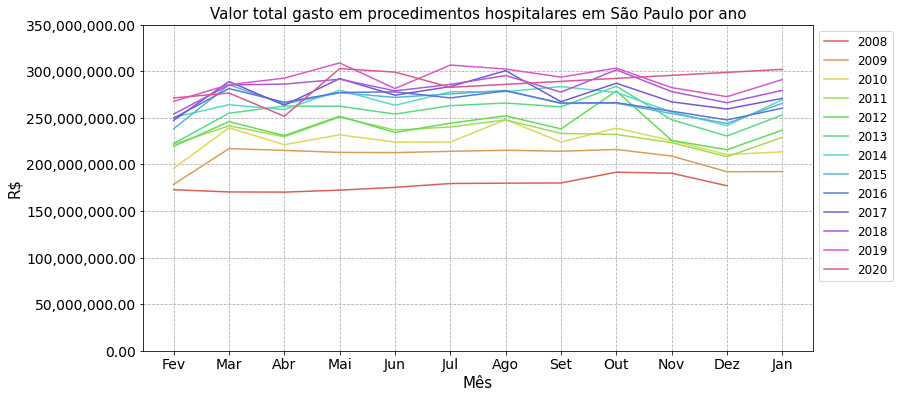

In [9]:
plt.figure(figsize = (12,6))
ax = sns.lineplot(data = mensal_aberto.query("uf == 'São Paulo'"), x = "mes_str", y = "gasto", hue = "ano", 
                  palette = sns.color_palette("hls", 13))
plt.title("Valor total gasto em procedimentos hospitalares em São Paulo por ano", fontsize = 15)
plt.ylim(0, 350)
ax.legend(bbox_to_anchor = (1,1), fontsize = 12)
plt.ylabel("R$", fontsize = 15)
plt.xlabel("Mês", fontsize = 15)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x*1000000)))
ax.tick_params(axis = 'both', which = 'major', labelsize = 14)
plt.grid(linestyle = "--")
plt.show()

Aqui, reparei que há um problema: nossos dados começam em Fevereiro, e para uma visualização mais interessante, seria melhor começar com os dados em Janeiro. Isso ocorre porque o primeiro ano que nós temos dados é 2008, que não possui dados de Janeiro. Uma forma de contornar esse problema é configurar a coluna como "categorical" e ordenar dizendo que Janeiro é o primeiro mês. Dessa forma, o matplotlib vai entender que o gráfico deve começar em Janeiro

https://stackoverflow.com/questions/13838405/custom-sorting-in-pandas-dataframe :

In [10]:
mensal_aberto.loc[:,"mes_str"] = pd.Categorical(mensal_aberto.loc[:,'mes_str'],["Jan", "Fev", "Mar", "Abr", "Mai", "Jun", "Jul", "Ago", "Set", "Out", "Nov", "Dez"])
mensal_aberto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4050 entries, 0 to 4049
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   dia_mes_ano  4050 non-null   datetime64[ns]
 1   uf           4050 non-null   object        
 2   gasto        4050 non-null   float64       
 3   mes          4050 non-null   int64         
 4   ano          4050 non-null   int64         
 5   mes_str      4050 non-null   category      
dtypes: category(1), datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 162.7+ KB


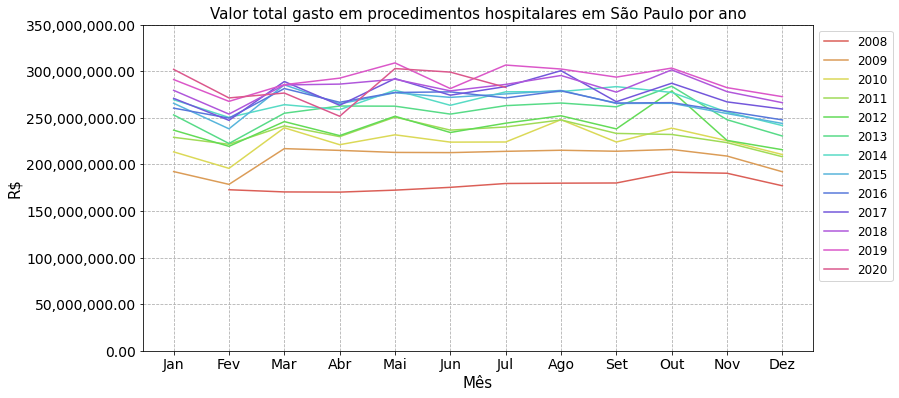

In [11]:
plt.figure(figsize = (12,6))
ax = sns.lineplot(data = mensal_aberto.query("uf == 'São Paulo'"), x = "mes_str", y = "gasto", hue = "ano", 
                  palette = sns.color_palette("hls", 13))
plt.title("Valor total gasto em procedimentos hospitalares em São Paulo por ano", fontsize = 15)
plt.ylim(0, 350)
ax.legend(bbox_to_anchor = (1,1), fontsize = 12)
plt.ylabel("R$", fontsize = 15)
plt.xlabel("Mês", fontsize = 15)
ax.tick_params(axis = 'both', which = 'major', labelsize = 14)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x*1000000)))
plt.grid(linestyle = "--")
plt.show()

## Seguindo

In [12]:
dias_por_mes = {
    1 : 31,
    2 : 28,
    3 : 31,
    4 : 30,
    5 : 31,
    6 : 30,
    7 : 31,
    8 : 31,
    9 : 30,
    10 : 31,
    11 : 30,
    12 : 31
}

In [13]:
mensal_aberto.loc[:, "gasto_diario"] = mensal_aberto.loc[:, "gasto"] / mensal_aberto.loc[:,"mes"].map(dias_por_mes)

In [14]:
mensal_aberto.head()

,dia_mes_ano,uf,gasto,mes,ano,mes_str,gasto_diario
0,2008-02-01,São Paulo,172.83,2,2008,Fev,6.17
1,2008-03-01,São Paulo,170.48,3,2008,Mar,5.50
2,2008-04-01,São Paulo,170.28,4,2008,Abr,5.68
3,2008-05-01,São Paulo,172.40,5,2008,Mai,5.56
4,2008-06-01,São Paulo,175.42,6,2008,Jun,5.85


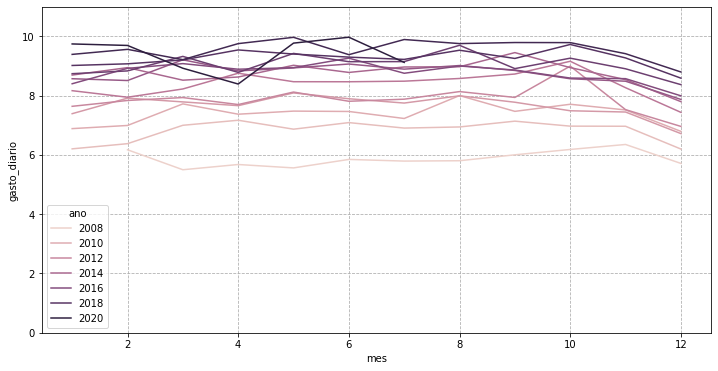

In [15]:
plt.figure(figsize = (12,6))
ax = sns.lineplot(data = mensal_aberto.query("uf == 'São Paulo'"), x = "mes", y = "gasto_diario", hue = "ano")
plt.ylim(0,11)
plt.grid(linestyle = "--")
plt.show()

## Desafio 02 - Pegar estados de climas diferentes (por exemplo, Norte e Sul) e plotar o gráfico de linhas, comparar ambos e compartilhar suas análises:

In [43]:
para = mensal_aberto.query("uf == 'Pará'")
rio_grande = mensal_aberto.query("uf == 'Rio Grande do Sul'")

estados = para.append(rio_grande)
estados

,dia_mes_ano,uf,gasto,mes,ano,mes_str,gasto_diario
1500,2008-02-01,Pará,20.13,2,2008,Fev,0.72
1501,2008-03-01,Pará,22.15,3,2008,Mar,0.71
1502,2008-04-01,Pará,23.44,4,2008,Abr,0.78
1503,2008-05-01,Pará,23.86,5,2008,Mai,0.77
1504,2008-06-01,Pará,23.50,6,2008,Jun,0.78
...,...,...,...,...,...,...,...
595,2020-03-01,Rio Grande do Sul,84.65,3,2020,Mar,2.73
596,2020-04-01,Rio Grande do Sul,76.29,4,2020,Abr,2.54
597,2020-05-01,Rio Grande do Sul,86.08,5,2020,Mai,2.78
598,2020-06-01,Rio Grande do Sul,89.02,6,2020,Jun,2.97


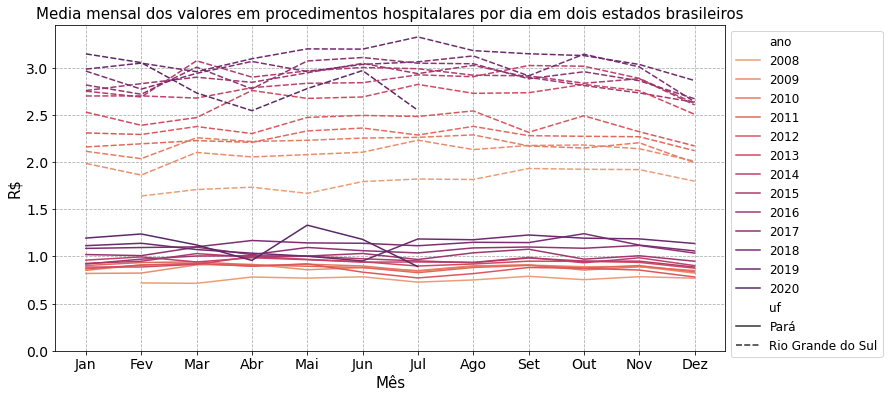

In [52]:
plt.figure(figsize = (12,6))
ax = sns.lineplot(data = estados, x = "mes_str", y = "gasto_diario", hue = "ano", palette = sns.color_palette("flare", 13),
                  style = "uf")
plt.title("Media mensal dos valores em procedimentos hospitalares por dia em dois estados brasileiros", fontsize = 15)
plt.ylim(0)
ax.legend(bbox_to_anchor = (1,1), fontsize = 12)
plt.ylabel("R$", fontsize = 15)
plt.xlabel("Mês", fontsize = 15)
ax.tick_params(axis = 'both', which = 'major', labelsize = 14)
plt.grid(linestyle = "--")
plt.show()

Olhando para a nossa figura, que compara o gasto médio diário a cada mês entre os estados do Pará e Rio Grande do Sul, dois estados com climas bastante diferentes, não parece haver periodicidade alguma nos gastos com procedimentos hospitalares. Uma hipótese levantada pelo Thiago durante as aulas seria que há uma variação decorrente da periodicidade dos casos de dengue. Difícil analisar essa hipótese considerando o total de gastos com procedimentos hospitalares, seria mais interessante discriminar melhor o tipo de gasto durante a query no sistema do tabnet/datasus.